# Working with modern sequence formats

In this notebook, we'll use the Humans 1,000 genomes project data to explore
the usage of FASTQ files with their quality score for each base.

One of the main challenges of using NGS data is the raw size of the data.
Due to it's large nature, we must be aware of ways to handle disk space and
backup policies.

<!-- ```python -->
<!-- !rm -f SRR003265.filt.fastq.gz 2>/dev/null -->
<!-- !wget -nd ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265.filt.fastq.gz -->
<!-- ``` -->

In [1]:
import gzip
from Bio import SeqIO
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
rec = next(recs)
print(rec.id, rec.description, rec.seq)
print(rec.letter_annotations)

SRR003265.31 SRR003265.31 3042NAAXX:3:1:1252:1819 length=51 GGGAAAAGAAAAACAAACAAACAAAAACAAAACACAGAAACAAAAAAACCA
{'phred_quality': [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 23, 40, 32, 35, 29, 40, 16, 40, 40, 32, 35, 31, 40, 40, 39, 22, 40, 24, 20, 28, 31, 12, 31, 10, 22, 28, 13, 26, 20, 23, 23]}


note that here `recs` holds an iterator with the contents of the FASTQ file. This means
that if we were to convert this iterator to a list, it might eat our whole RAM. **The 
safest way to manipulate data in a FASTQ file is to either do all manipulations in a 
single iteration or open and close the file multiple times over.**

### taking a look at the distribution of nucleotide reads:



In [2]:
from collections import defaultdict
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
cnt = defaultdict(int)
for rec in recs:
  for letter in rec.seq:
    cnt[letter] += 1
tot = sum(cnt.values())
for letter, count in cnt.items():
  print(f"{letter}: {(100.*count/tot):.2f} {count}")

G: 20.68 5359334
A: 28.60 7411965
C: 21.00 5444053
T: 29.58 7666885
N: 0.14 37289


Here, N's represent faulty data, or base pairs that could not be identified.

### plotting the distribution of unidentified base pairs according to their reading position:

before doing this recipe, I wondered: whats the length of each sequence in the record?


In [3]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
avg_len = 0
seq_cnt = 0
for rec in recs:
  avg_len += len(rec.seq) 
  seq_cnt += 1
avg_len /= seq_cnt
print(avg_len)

51.0


For some reason, these are really small sequences. I could not find in the book the reason why,
nor what gene is this sequence from, except it is from Youruban people.

Let's continue with the plot of the distance until the unidentified bases:

Text(0, 0.5, 'Number of N Calls')

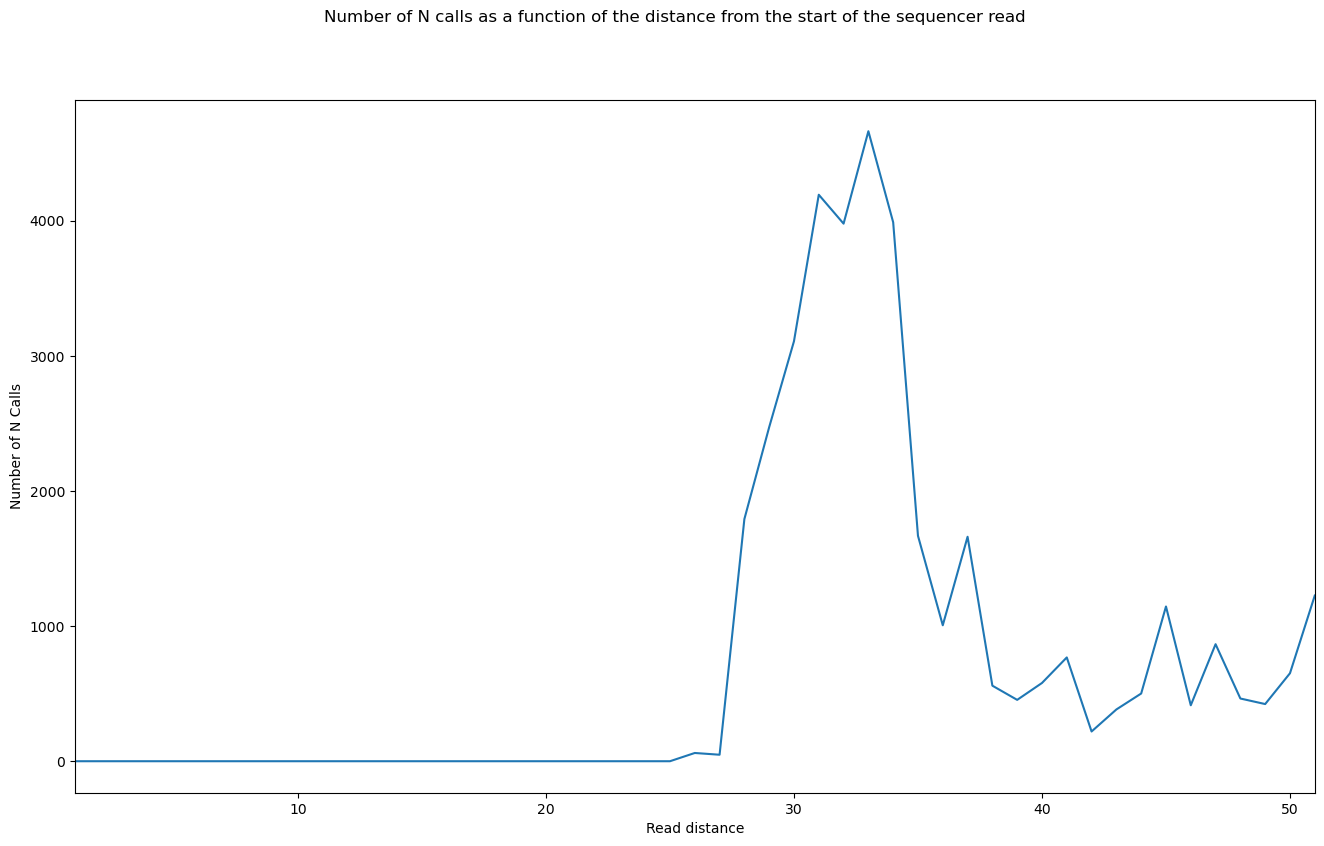

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
n_cnt = defaultdict(int)
for rec in recs:
  for i, letter in enumerate(rec.seq):
    if letter == 'N':
      n_cnt[i+1] += 1
seq_len = max(n_cnt.keys())
positions = range(1, seq_len + 1) # these will serve as x axis
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(positions, [n_cnt[x] for x in positions])
fig.suptitle('Number of N calls as a function of the distance from the start of the sequencer read')
ax.set_xlim(1, seq_len)
ax.set_xlabel('Read distance')
ax.set_ylabel('Number of N Calls')

We can see that there are no errors until the 25th position.
This is due to the 1000 genomes filtering rule that enforces
no N calls until the 25th position. We can notice from the
graph, however, that the distribution of N bases seems to not
be uniform, and thus is position dependent.
What about the quality of our reads?

### Studying quality of reads (phred scores) based on position

In [5]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
len_recs = 0
avg_quality = defaultdict(float)
for rec in recs:
  len_recs += 1
  phred = rec.letter_annotations['phred_quality']
  for pos in range(len(rec.seq)):
    avg_quality[pos+1] += phred[pos]
for pos in range(len_recs):
  avg_quality[pos+1] /= len_recs

Text(0, 0.5, 'Average Quality')

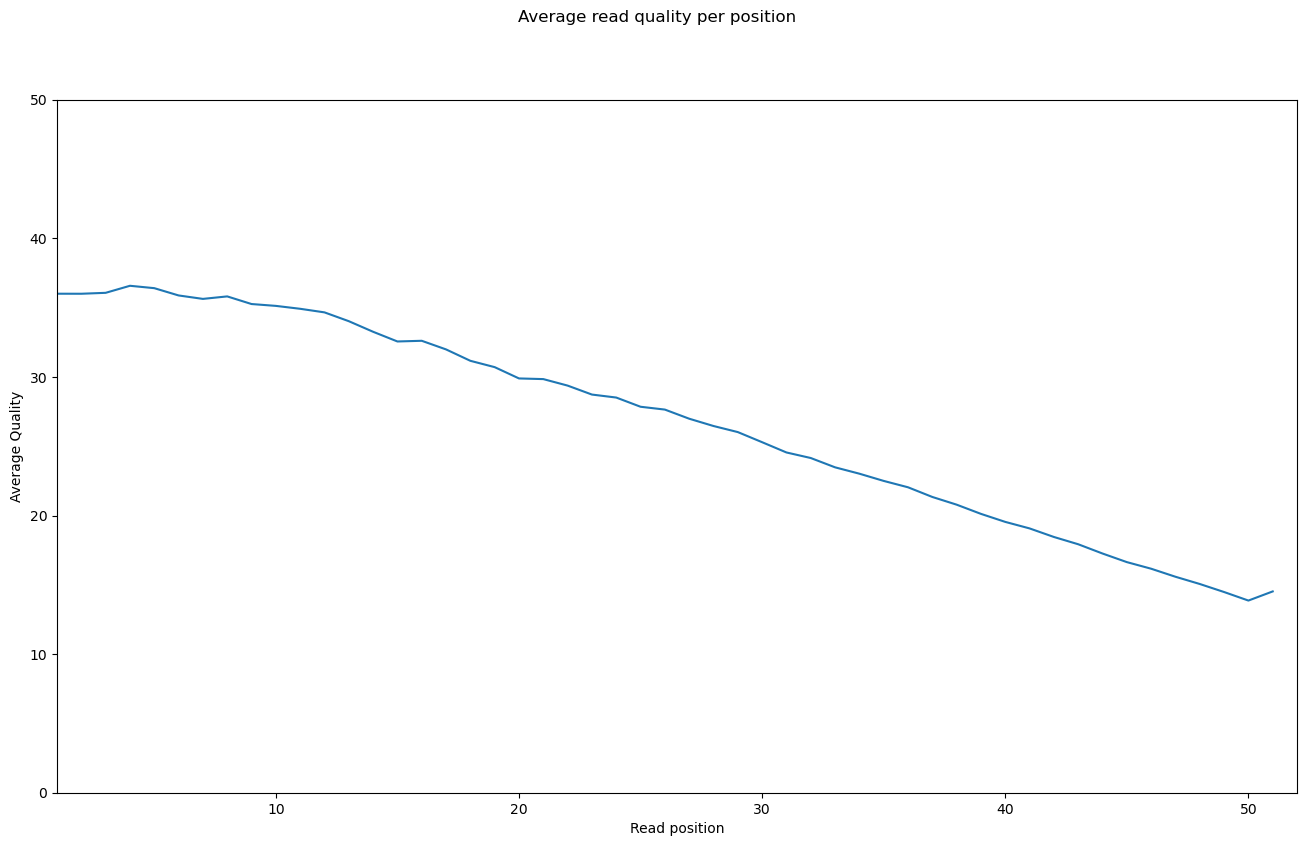

In [6]:
positions = range(1, 52)
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(positions, [avg_quality[x] for x in positions])
fig.suptitle('Average read quality per position')
ax.set_xlim(1, 52)
ax.set_ylim(0,50)
ax.set_xlabel('Read position')
ax.set_ylabel('Average Quality')

#### The book's solution

The bioinformatics cookbook creates this graph in a fancier way. I'll copy it below:

In [7]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
cnt_qual = defaultdict(int)
for rec in recs:
  for i, qual in enumerate(rec.letter_annotations['phred_quality']):
    if i < 25:
      continue
    cnt_qual[qual] += 1
tot = sum(cnt_qual.values())
for qual, cnt in cnt_qual.items():
  print(f"{qual}: {100.*cnt/tot:.2f} {cnt}")

40: 22.76 3007221
16: 2.05 270431
32: 1.03 136763
35: 0.91 120704
31: 1.08 142464
39: 0.78 102568
22: 1.59 209905
24: 1.46 193259
20: 1.73 228923
28: 1.23 162226
12: 2.35 309918
10: 4.95 654154
13: 2.28 301033
26: 1.33 176263
23: 1.52 201164
37: 0.84 111179
34: 0.95 125624
21: 1.66 219602
30: 1.13 149449
33: 0.99 131291
25: 1.40 184846
17: 1.97 259779
38: 0.80 106290
4: 4.77 630923
36: 0.88 115701
18: 1.88 248982
11: 2.41 318303
19: 1.81 239621
5: 4.88 645266
9: 2.51 332259
3: 4.04 533458
27: 1.28 168902
8: 2.53 334410
29: 1.17 154892
15: 2.12 280719
7: 2.51 331743
2: 3.77 498679
14: 2.20 291341
6: 2.50 330834
1: 1.52 200558
0: 0.40 52229


/tmp/ipykernel_87828/1910569279.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(x) for x in range(26, max(qual_pos.keys()) + 1)])


Text(0.5, 0.98, 'Distribution of PHRED scores as a function of read distance')

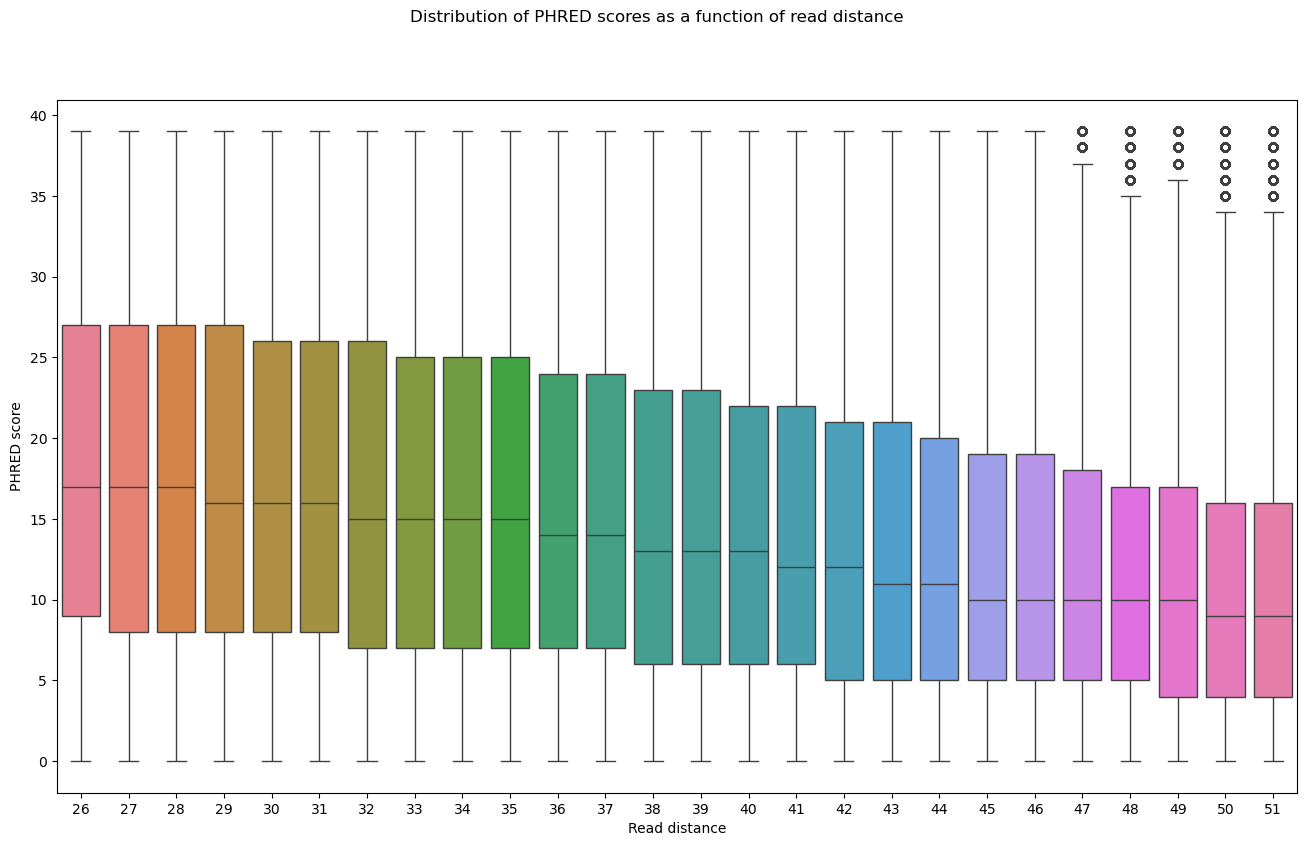

In [8]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
qual_pos = defaultdict(list)
for rec in recs:
  for i, qual in enumerate(rec.letter_annotations['phred_quality']):
    if i < 25 or qual == 40:
      continue
    pos = i+1
    qual_pos[pos].append(qual)
vps = []
poses = list(qual_pos.keys())
poses.sort()
for pos in poses:
  vps.append(qual_pos[pos])
fig, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data = vps, ax=ax)
ax.set_xticklabels([str(x) for x in range(26, max(qual_pos.keys()) + 1)])
ax.set_xlabel('Read distance')
ax.set_ylabel('PHRED score')
fig.suptitle('Distribution of PHRED scores as a function of read distance')


## Summarizing:

We learned:
- to iterate fasta files to avoid memory allocation of the whole file;
- the contents of the fastq file, which include relevant metadata such as read quality;
- how read quality works (that is, in a log-fashion where 10 = 90% accuracy)
- some attributes of the `SeqIO.parse()` method, such as the phred_quality and the sequence itself;
- how to visualise and extract relevant data such as phred_quality as a function of base position;
- the existance of 'N' bases, which mean unidentified nucleotides; 
- some basics of plotting, and the fact that we need to develop this area!